# Classifying Online Comments as Toxic or Non-Toxic

## Importing libraires and loading the dataset

In [1]:
# importing libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# for HTML tags
from bs4 import BeautifulSoup
import re

# for stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
import nltk 

# for collections
from collections import Counter

# for word cloud
from wordcloud import WordCloud

# for Regression Analysis 
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler

# for pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import ComplementNB
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB

# for Grid Search
from sklearn.model_selection import GridSearchCV

# for cross-validation
from sklearn.model_selection import cross_validate
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, make_scorer

# for saving the best_estimators
import joblib

# for feature importance
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer

# for visualisation
from sklearn.tree import export_graphviz
from IPython.display import Image  
from subprocess import call

In [2]:
# Loading the dataset
comments = pd.read_csv("toxic_comments.csv")
comments.head()

,Unnamed: 0,text,toxic
0,0,you have yet to identify where my edits violat...,0
1,1,"""\n as i have already said,wp:rfc or wp:ani. (...",0
2,2,your vote on wikiquote simple english when it ...,0
3,3,your stalking of my edits i've opened a thread...,0
4,4,straight from the smear site itself. the perso...,1


## Exploratory Data Analysis (EDA)
The EDA process involves the following steps: (Source: https://www.geeksforgeeks.org/what-is-exploratory-data-analysis/).

#### Understanding the problem and the data:
Abuse detection is the task of identifying abusive behaviours, such as hate speech, offensive language, sexism and racism, in utterances from social media platforms. This project investigates this complex problem and classifies online comments into toxic or non-toxic text. 

#### Inspecting the data:
The comments.info() method prints information about the comments dataframe including the number of columns, column labels, column data types and the number of cells in each column (non-null values) and memory usage. (Source: https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.info.html)

Interpretation: 

The comments dataframe has 5 000 entries and three dataset attributes namely "Unnamed", "toxic" and "text". The "Unnamed" column refers to the individual comments with a unique identification number and is of type integer. The "toxic" column refers to the comment's class label whereby 0 indicates that the comment's class is non-toxic and 1 indicates that the comment's class is toxic. The data type in the "toxic" column is of type integer. The "text" column refers to the comment's text and is of type object. The "Unnamed: 0" column is unnecessary to include in the comments dataframe as the data in the "Unnamed: 0" column matches that of the observation column values. Therefore, the "Unnamed" column can be dropped from the dataframe. Additionally, any duplicated data is removed from the dataframe.

In [3]:
comments.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  5000 non-null   int64 
 1   text        5000 non-null   object
 2   toxic       5000 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 117.3+ KB


In [4]:
# Remove any duplicate rows and coulmns not needed.
comments_no_duplicates = comments.drop_duplicates()
comments.drop(['Unnamed: 0'], inplace =True, axis=1)
comments.head()

,text,toxic
0,you have yet to identify where my edits violat...,0
1,"""\n as i have already said,wp:rfc or wp:ani. (...",0
2,your vote on wikiquote simple english when it ...,0
3,your stalking of my edits i've opened a thread...,0
4,straight from the smear site itself. the perso...,1


#### Handle Missing Data

The comments dataframe is checked for missing values and their distribution across variables, as missing information can notably affect the quality and reliability of the evaluation. In this case there are no missing values, therefore we do not need to remove any missing vlaues.

In [5]:
# Number of missing data points per column
missing_values_count = comments.isnull().sum() 
print(missing_values_count)

text     0
toxic    0
dtype: int64


#### Explore data characteristics:

Examining the variables’ distribution, crucial tendency, and variability and identifying any ability outliers or anomalies using the comments.describe() method. (Source: https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.describe.html) the descriptive statistics include those that summarize the central tendency, dispersion and shape of a dataset’s distribution, excluding NaN values for both the numeric ("Toxic") and object ("Text") series. 

In [6]:
# Summarise the statistical properties of the columns
stats = comments.describe(include='all')
stats

,text,toxic
count,5000,5000.000000
unique,4999,NaN
top,very short and very clear slaves - to gas cham...,NaN
freq,2,NaN
mean,NaN,0.130000
std,NaN,0.336337
min,NaN,0.000000
25%,NaN,0.000000
50%,NaN,0.000000
75%,NaN,0.000000


#### Visual: Bar chart showing the counts for the toxicity.

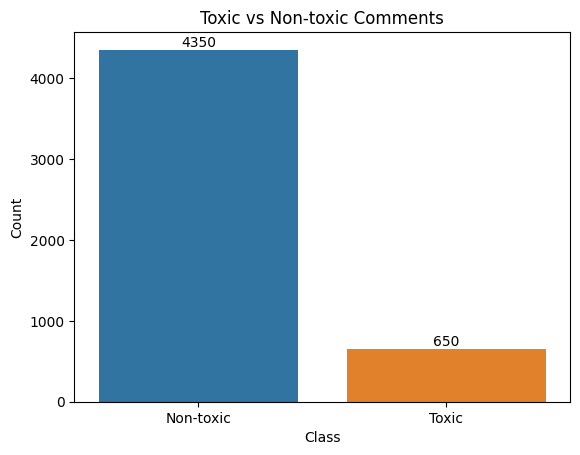

In [7]:
# Replace the values in the "toxic" column to be better represented. 
comments['toxic'] = comments['toxic'].replace({0: 'Non-toxic', 1: 'Toxic'})

# Create a bar chart of counts using countplot
ax = sns.countplot(data=comments, x='toxic')

# Add the number on top of each bar (Source: )
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.0f'), 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha = 'center', va = 'center',
                xytext = (0, 5), 
                textcoords = 'offset points')

plt.title("Toxic vs Non-toxic Comments")
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()

#### Interpretation: 

The comments dataframe is highly imbalanced as there are more non-toxic comments (4 350 comments) than there are of toxic comments (650 comments) in the dataset. 

#### Perform Data Transformation

Will need to perform operations specific to strings, like concatenation, substring extraction, or regular expression matching, thus the "text" column will need to be converted from object type to string type.

In [8]:
# Convert the "text" column to string data type.
comments['text'] = comments['text'].astype("string")
           
# Get the data type of the columns after conversion
comments.dtypes

text     string[python]
toxic            object
dtype: object

Handling categorical varaibles such as the 'Toxic' column is better represented in the machine if changed to numerical data, therefore will need to revert the "toxic" values back into numerical representation. Will use One-hot encoding where "toxic" is assigned [1, 0] and [0, 1] is for "non-toxic".

In [9]:
# Replace the toxic values into numerical values.
comments['toxic'] = comments['toxic'].replace({'Non-toxic': 0, 'Toxic': 1})

C:\Users\aikat\AppData\Local\Temp\ipykernel_19416\818555027.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  comments['toxic'] = comments['toxic'].replace({'Non-toxic': 0, 'Toxic': 1})


## Preprocessing Text

Text preprocessing is important for performing sentiment analysis, as it helps to clean and normalize the text data, making it easier to analyze (Source: https://medium.com/@maleeshadesilva21/preprocessing-steps-for-natural-language-processing-nlp-a-beginners-guide-d6d9bf7689c9).

Some techniques includes converting to lowercase, removing HTML tags, special characters, digits, and stop words. Removing common and irrelevant words that are unlikely to convey much sentiment. Stop words are words that are very common in a language and do not carry much meaning, such as "and," "the," "of," and "it." These words can cause noise and skew the analysis if they are not removed.

In [10]:
# Function to perform the pre-processing steps on the "text" column to clean the dataset.
def pre_processing(text):
    # Removes the HTML tags
    review_text = BeautifulSoup(text, 'html.parser').get_text()
    
    # Replaces the non-letter words using a regular expression with spaces and converts to lower case.
    letter_only = re.sub("[^a-zA-Z]", " ", review_text).lower()
    
    # Splitting into individual words and removes stop words
    stop_words = set(stopwords.words('english'))   # Get English stop words
    whitelist = ["n't", "not", "no"]  # Do not remove these
    words = letter_only.split() 
    clean_words = [word for word in words if (word not in stop_words or word in whitelist) and len(word) > 1] 

    # Return the words as a single concatenated string 
    cleaned_text = " ".join(clean_words) 
    return cleaned_text

comments['clean_text'] = comments['text'].apply(pre_processing)
comments.head()

C:\Users\aikat\AppData\Local\Temp\ipykernel_19416\1954998991.py:4: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  review_text = BeautifulSoup(text, 'html.parser').get_text()


,text,toxic,clean_text
0,you have yet to identify where my edits violat...,0,yet identify edits violated policy july utc
1,""" as i have already said,wp:rfc or wp:ani. (t...",0,already said wp rfc wp ani talk track
2,your vote on wikiquote simple english when it ...,0,vote wikiquote simple english comes using syso...
3,your stalking of my edits i've opened a thread...,0,stalking edits opened thread stalking edits
4,straight from the smear site itself. the perso...,1,straight smear site person called dissident so...


In [11]:
# Function to count the number of words in clean_text in 
def count_words(text):
    num_words = len(text.split())
    return num_words

# Store the clean data into a new dataframe and add the column that counts the number of words. 
comments['Number of words'] = comments['clean_text'].apply(count_words)
comments.head()

,text,toxic,clean_text,Number of words
0,you have yet to identify where my edits violat...,0,yet identify edits violated policy july utc,7
1,""" as i have already said,wp:rfc or wp:ani. (t...",0,already said wp rfc wp ani talk track,8
2,your vote on wikiquote simple english when it ...,0,vote wikiquote simple english comes using syso...,56
3,your stalking of my edits i've opened a thread...,0,stalking edits opened thread stalking edits,6
4,straight from the smear site itself. the perso...,1,straight smear site person called dissident so...,11


In [12]:
# Initialize Counters
toxic_word_counter = Counter()
non_toxic_word_counter = Counter()

# Function to tokenize text into words
def tokenize(text):
    # Convert text to lowercase and gets individual words as separate elements in a list.
    words = re.findall(r'\b\w+\b', text.lower())
    # Remove stop words such as "and", "the", "is" and "you".
    filtered_words = [word for word in words if word not in stop_words] 
    return filtered_words

# Iterate through comments dataframe rows
# References: https://www.learndatasci.com/solutions/how-iterate-over-rows-pandas/ and https://www.geeksforgeeks.org/python-counter-update-method/
def update_counters(row):
    words = tokenize(row['clean_text'])
    if row['toxic'] == 1:
        toxic_word_counter.update(words)   # Adds the counts of its elements to the existing counts in the Counter. 
    else:
        non_toxic_word_counter.update(words)

# Apply the function to each row
comments.apply(update_counters, axis=1)

# Get the top 5 most common words
top_toxic_words = toxic_word_counter.most_common(5)
top_non_toxic_words = non_toxic_word_counter.most_common(5)

# Create DataFrames for display
df_top_toxic = pd.DataFrame(top_toxic_words, columns=['Word', 'Count'])
df_top_non_toxic = pd.DataFrame(top_non_toxic_words, columns=['Word', 'Count'])

# Display the results in a table format for better display.
print("Top 5 Common Toxic Words:")
print(df_top_toxic.to_string(index=False))

print("\nTop 5 Common Non-Toxic Words:")
print(df_top_non_toxic.to_string(index=False))

Top 5 Common Toxic Words:
     Word  Count
buttsecks    497
     hate    468
 bastered    435
    idiot    308
    vomit    217

Top 5 Common Non-Toxic Words:
     Word  Count
  article   1252
     page    974
     talk    895
wikipedia    863
   please    736


#### Visual: Generate word clouds for toxic and non-toxic text.

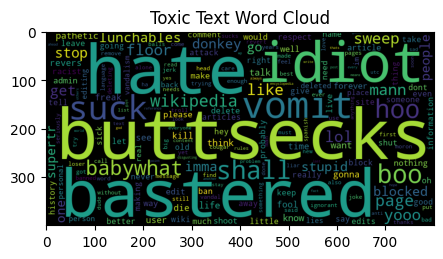

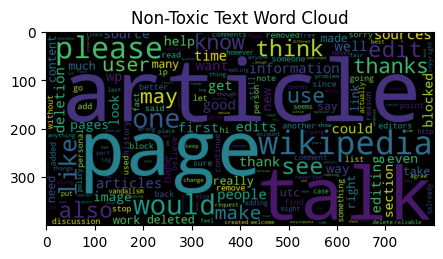

In [13]:
# Referecmes: https://www.datacamp.com/tutorial/wordcloud-python
# https://towardsdatascience.com/how-to-create-beautiful-word-clouds-in-python-cfcf85141214
def word_cloud(word_counter, title):
    wc = WordCloud(width=800, height=400).generate_from_frequencies(word_counter)
    plt.figure(figsize=(5, 5))
    plt.imshow(wc)
    plt.axis("on")
    plt.title(title)
    plt.show()

# Display word clouds with respectable titles.
word_cloud(toxic_word_counter, 'Toxic Text Word Cloud')
word_cloud(non_toxic_word_counter, 'Non-Toxic Text Word Cloud')

## Modelling

#### Identify the independent and dependent varibles.
The x values (dependent variables) is the text values and the y value (independent variables) is the toxic values.

In [14]:
X = comments['clean_text'].values    # x values - clean_text columns
Y = comments['toxic'].values         # y values - toxic column

#### Split the data into training and test set

In [15]:
# Split the original dataset into training and test sets (80% and 20%).
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 42)

# Provide the dimensions (shape) of the training and test feature matrix (nr of samaples, nr of features).
print ("Training data:",X_train.shape, y_train.shape)
print ("Test data:",X_test.shape, y_test.shape)

Training data: (4000,) (4000,)
Test data: (1000,) (1000,)


#### Piplines

Pipelines combine multiple steps of data processing and model training into a single workflow, ensuirng each step of the process is executed in a specific order and maintain consistency throughout the workflow. (Source: https://towardsdatascience.com/pipeline-for-text-data-pre-processing-a9887b4e2db3).

TfidfVectorizer: Converts text data into a matrix of TF-IDF features (Source: https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html).

The three pipelines are as follows:
1. LogisticRegression: A linear model for binary classification tasks (Source: https://www.geeksforgeeks.org/understanding-logistic-regression/).
2. RandomForestClassifier: A combination of methods using multiple decision trees (Source: https://www.geeksforgeeks.org/random-forest-classifier-using-scikit-learn/).
3. MultinomialNB: A Naive Bayes classifier suited for text classification (https://www.geeksforgeeks.org/multinomial-naive-bayes/).

In [16]:
# Funtion creates a pipleine with TfidfVectorizer and a specified classifier (LogisticRegression, RandomForestClassifier, MultinomialNB).
def pipeline(classifier):
    pipeline = Pipeline([
        ("tfidf", TfidfVectorizer(analyzer = "word")),   # TfidfVectorizer
        ("clf", classifier)])                            # Specified Classifier
    return pipeline

# Print the pipeline steps
def steps(pipeline, classifier):
    print(f"\nPipeline steps for {classifier}:")
    for step_name, step_process in pipeline.steps:
        print(f"{step_name}: {step_process}")

# Create pipelines with different classifiers.
pipeline_lr = pipeline(LogisticRegression(max_iter=2000, random_state=42))
pipeline_rf = pipeline(RandomForestClassifier(random_state=42))
pipeline_nb = pipeline(MultinomialNB())

# Print the steps for all three pipelines.
pipeline_step_lr = steps(pipeline_lr, 'LogisticRegression')
pipeline_step_rf = steps(pipeline_rf, 'RandomForestClassifier')
pipeline_step_nb = steps(pipeline_nb, 'MultinomialNB')


Pipeline steps for LogisticRegression:
tfidf: TfidfVectorizer()
clf: LogisticRegression(max_iter=2000, random_state=42)

Pipeline steps for RandomForestClassifier:
tfidf: TfidfVectorizer()
clf: RandomForestClassifier(random_state=42)

Pipeline steps for MultinomialNB:
tfidf: TfidfVectorizer()
clf: MultinomialNB()


In [17]:
# Functions trains and evaluates the three differnet pipelines on the test set.
def train_and_evaluate(pipeline, X_train, y_train, X_test):
    pipeline.fit(X_train, y_train)       # Train the pipeline
    y_pred = pipeline.predict(X_test)    # Make predictions on the test set
    return y_pred

# Train and evaluate with different pipelines.
# y_pred_lr = train_and_evaluate(pipeline_lr, X_train, y_train, X_test)
# y_pred_rf = train_and_evaluate(pipeline_rf, X_train, y_train, X_test)
# y_pred_nb = train_and_evaluate(pipeline_nb, X_train, y_train, X_test) 

#### Hyperparameter tuning using GridSearchCV
Grid SearchCV does a search over a specified parameter grid for each model, helping to find the best combination of hyperparameters (Source: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html).

In [18]:
# Function to perform grid search for given pipeline and parameter grid.
def grid_search(pipeline, param_grid, X_train, y_train):
    # Create GridSearchCV object
    grid_search = GridSearchCV(pipeline, param_grid, n_jobs=-1, cv=5)  # Adjust cv and n_jobs as needed

    # Fit GridSearchCV
    grid_search.fit(X_train, y_train)

    # Get best parameters, best estimator and best score
    best_params = grid_search.best_params_
    best_estimator = grid_search.best_estimator_
    best_score = grid_search.best_score_

    # Print best parameters and score
    print(f"\nBest parameters found: {best_params}")
    print(f"Best score: {best_score}")

    return best_estimator, best_params, best_score

# Define parameter grids for each classifier
param_grid_lr = {'clf__C': [0.001, 0.01, 0.1, 1, 10, 100]}  # Hyperparameters for Logistic Regression 
param_grid_rf = {'clf__criterion': ['gini', 'entropy']}  # Hyperparameters for RandomForestClassifier
param_grid_nb = {'clf__fit_prior': [True, False],'clf__alpha': np.linspace(0.5, 1.5, 6)}   # Hyperparameter for MultinomialNB

# Perform grid search for each pipeline
best_logit, best_params_lr, best_score_lr = grid_search(pipeline_lr, param_grid_lr, X_train, y_train)
best_forest, best_params_rf, best_score_rf = grid_search(pipeline_rf, param_grid_rf, X_train, y_train)
best_nmb, best_params_nb, best_score_nb = grid_search(pipeline_nb, param_grid_nb, X_train, y_train)

# To evaluate on test set
y_pred_lr = best_logit.predict(X_test)
y_pred_rf = best_forest.predict(X_test)
y_pred_nb = best_nmb.predict(X_test)


Best parameters found: {'clf__C': 100}
Best score: 0.90725

Best parameters found: {'clf__criterion': 'gini'}
Best score: 0.9065000000000001

Best parameters found: {'clf__alpha': 0.5, 'clf__fit_prior': False}
Best score: 0.8915000000000001


#### Retrain model using 5-fold cross validation.

In [19]:
# Define the models 
models = {'Logistic Regression': best_logit, 'Random Forest': best_forest, 'Multinomial Naive Bayes': best_nmb}

# Define metrics and scoring functions
# Reference: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.make_scorer.html
scoring = {
    'accuracy': 'accuracy',
    'precision_weighted': make_scorer(precision_score, average='weighted'),
    'recall_weighted': make_scorer(recall_score, average='weighted'),
    'f1_weighted': make_scorer(f1_score, average='weighted')}

# Loop over models and compute cross-validation scores
for name, model in models.items():
    print(f"\nEvaluating model: {name}")
    
    # Perform cross-validation
    scores = cross_validate(model, X_train, y_train, cv=5, scoring=scoring, return_train_score=False)
    
    # Compute mean and standard deviation for each metric
    mean_accuracy = scores['test_accuracy'].mean()
    std_accuracy = scores['test_accuracy'].std()
    
    mean_precision = scores['test_precision_weighted'].mean()
    std_precision = scores['test_precision_weighted'].std()
    
    mean_recall = scores['test_recall_weighted'].mean()
    std_recall = scores['test_recall_weighted'].std()
    
    mean_f1 = scores['test_f1_weighted'].mean()
    std_f1 = scores['test_f1_weighted'].std()
    
    # Print values. 
    print(f"Accuracy: {mean_accuracy:.4f} ± {std_accuracy:.4f}")
    print(f"Precision: {mean_precision:.4f} ± {std_precision:.4f}")
    print(f"Recall: {mean_recall:.4f} ± {std_recall:.4f}")
    print(f"F1 Score: {mean_f1:.4f} ± {std_f1:.4f}")


Evaluating model: Logistic Regression
Accuracy: 0.9073 ± 0.0048
Precision: 0.8976 ± 0.0065
Recall: 0.9073 ± 0.0048
F1 Score: 0.8948 ± 0.0059

Evaluating model: Random Forest
Accuracy: 0.9065 ± 0.0017
Precision: 0.9089 ± 0.0048
Recall: 0.9065 ± 0.0017
F1 Score: 0.8844 ± 0.0033

Evaluating model: Multinomial Naive Bayes
Accuracy: 0.8915 ± 0.0015
Precision: 0.8767 ± 0.0021
Recall: 0.8915 ± 0.0015
F1 Score: 0.8791 ± 0.0024


#### Test and evalute all three models on the held out dataset.

In [20]:
# Define the models
models = {'Logistic Regression': best_logit, 'Random Forest': best_forest, 'Multinomial Naive Bayes': best_nmb}

# Initialize a dictionary to store results
metrics = {}

# Loop through the items in the models. 
for name, model in models.items():
    
    # Predict the labels for the test dataset
    y_pred = model.predict(X_test)
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred, average='weighted')
    precision = precision_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')

    # Store the results
    metrics[name] = {
        'Accuracy': accuracy,
        'Recall': recall,
        'Precision': precision,
        'F1 Score': f1}

# Convert the results dictionary to a DataFrame
metrics_df = pd.DataFrame(metrics)
print(f"Performance Metrics for three models: \n{metrics_df}")

Performance Metrics for three models: 
           Logistic Regression  Random Forest  Multinomial Naive Bayes
Accuracy              0.916000       0.904000                 0.905000
Recall                0.916000       0.904000                 0.905000
Precision             0.912466       0.907167                 0.896343
F1 Score              0.904824       0.883156                 0.894157


#### Interpretation

The table above gives specific metrics for each model and overall performance, whereas the metrics for the evaluation of each model provided a summary across multiple evaluations. Comparing the table's metrics to the evaluation model's metrics for recall and F1-score values might be challenging as the values vary depending on the various folds. However, the average accuracy value should align closely with the accuracy values reported in the table.

The Logistic Regression accuracy was 0.9073 and the classification report accuracy was 0.9160. The Random Forest accuracy was 0.9065 and the classification report accuracy was 0.904. The Multinomial Naive Bayes accuracy was 0.8915 and the classification report accuracy was 0.9050.


#### Visual: Bar chart showing the classification report of the three models. 

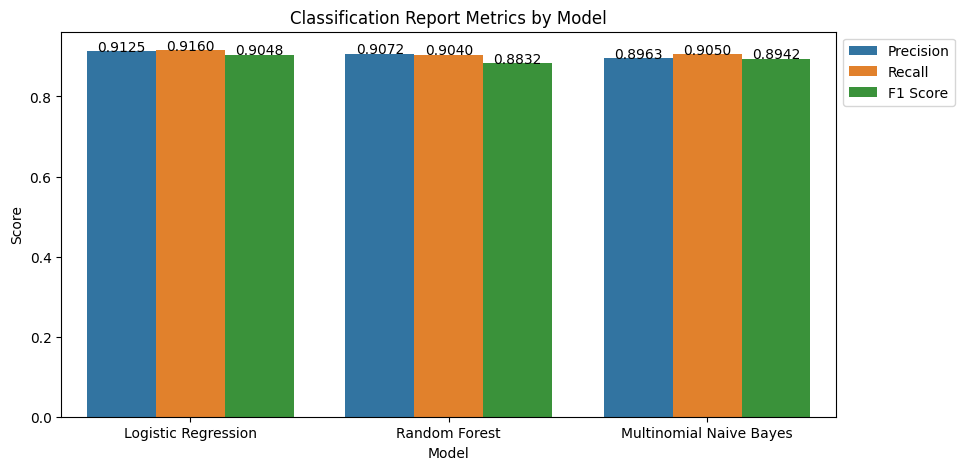

In [21]:
# Prepare the data from the report above.
data = {
    'Model': ['Logistic Regression', 'Random Forest', 'Multinomial Naive Bayes'],
    'Precision': [0.912466, 0.907167, 0.896343],
    'Recall': [0.916000, 0.904000, 0.905000],
    'F1 Score': [0.904824, 0.883156, 0.894157]}

df = pd.DataFrame(data)

# Melt the DataFrame for seaborn
df_melted = df.melt(id_vars='Model', var_name='Metric', value_name='Score')

# Create the plot
plt.figure(figsize=(10, 5))
ax = sns.barplot(x='Model', y='Score', hue='Metric', data=df_melted)

# Add values on top of the bars
for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{height:.4f}', 
                (p.get_x() + p.get_width() / 2., height), 
                ha='center', va='baseline')

ax.legend(loc='upper left', bbox_to_anchor=(1, 1))   # Move legend to the right of the plot
plt.title('Classification Report Metrics by Model')
plt.show()

#### Interpretation: 

The dataset is highly imbalanced as there are more non-toxic comments than there are of toxic comments with reference to the bar chart showing the class distribution. Therefore, for imbalanced datasets, precision, recall and F1-scores are more important than accuracy. The classifiers that optimize these metrics are preferred.

A high precision value indicates that a classifier can predict a positive outcome and is more likely to be correct. A higher recall value indicates that the classifier is successfully identifying a larger proportion of actual positive instances. A F1-score reflects a good balance between precision and recall. Therefore, the Logistic Regression model is the best classifier with precision value of 0.9125, recall value of 0.9160 and F1-score value of 0.9048. The Logistic Regression model values scored the highest between the three models.

In [22]:
# Print classification reports for logistic Regression model to 4 decimals places.
print(f"\n Classification report: Logistic Regression model:\n{classification_report(y_test, y_pred_lr, digits=4)}") 


 Classification report: Logistic Regression model:
              precision    recall  f1-score   support

           0     0.9201    0.9884    0.9530       862
           1     0.8649    0.4638    0.6038       138

    accuracy                         0.9160      1000
   macro avg     0.8925    0.7261    0.7784      1000
weighted avg     0.9125    0.9160    0.9048      1000



#### Interpretation:

The classification report gives specific metrics for each model and overall performance, whereas the metrics for the evaluation of each model provided a summary across multiple evaluations. Comparing the classification report to the evaluation model metrics for recall and F1-score values might be challenging as the values vary depending on the various folds. However, the average accuracy value should align closely with the accuracy values reported in the classification report. The Logistic Regression accuracy was 0.9160 and the classification report accuracy was 0.9160.

Considering the whole dataset, the model performed well enough to be able to recognise a text as being either toxic or non-toxic correctly. Regarding the precision for the classes, where the model predicted would be a toxic text, 92.01% were classified as non-toxic (class 0) and 86.49% were classified as toxic (class 1). For the recall of the classes, out of all the classes that the model predicted would be said text, 98.84% were classified as class 0 and 46.38% were classified as class 1. This means that model is successfully identifying a larger proportion of actual positive instances as class 0. Class 0 has a f1-score equal to 0.9530 which means that the model determined the text as non-toxic very accurately. The model struggled to determine class 1 as the toxic text with 60.38% accurately, which is still very high but less than class 0's f1-score. Among the classes in the test dataset, the highest samples/ instances presented in the dataset (137) were from class 0 and the least samples/ instances presented in the dataset are from class 1.

#### Confusion Matrix of the Logistic Regression Model

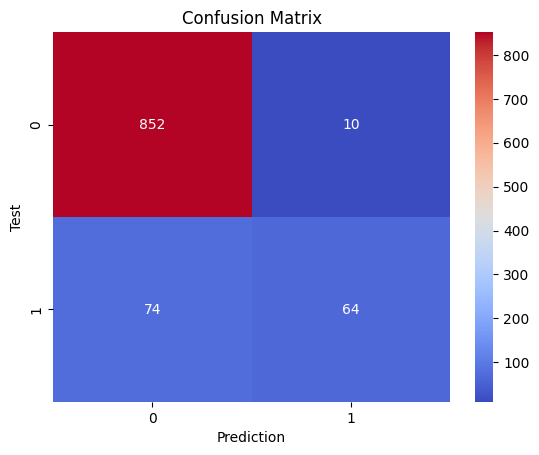

In [23]:
conf_mat = confusion_matrix(y_test, y_pred_lr)

# References: https://www.geeksforgeeks.org/confusion-matrix-machine-learning/
heatmap = sns.heatmap(conf_mat, annot=True, fmt='g', cmap='coolwarm')
plt.xlabel('Prediction')
plt.ylabel('Test')
plt.title('Confusion Matrix')
plt.show(heatmap)

#### Interpretation:

The confusion matrix is a representation of the what the model predicted compared to what is actually correct. The confusion matrix is evaluates the performance of a classification model. The model recognised 852 instances where the given non-toxic text was actually non-toxic (0), however the model misclassified the given text as toxic (1) in 10 instances. The model recognised 74 instances where the given toxic text was actually toxic (1), however the model misclassified the given text as non-toxic (0) in 64 instances.

The accuracy value is calculated as follows (TP+TN)/(TP+TN+FP+FN) which gives a value of 0.9160, indicating that the ratio of correctly predicted instances to the total instances is high. The precision value is calculated as follows TP/(TP+FP) which gives a value of 0.9125, indicating that a high value of the predicted positive cases were actually positive. The recall value is calculated as follows TP/(TP+FN) which gives a value of 0.9160, indicating a high value where positive cases were correctly identified. The F1-score value is calculated as follows Formula: 2×(Precision×Recall)/(Precision+Recall) which gives a value of 0.9048.


#### Prediction using the Logistic Regression

In [24]:
# Predict the label for the new sentences
# New sentences
sentence1 = ["the king is an awful human and must shut up"]
sentence2 = ["I really enjoyed the flight, but the food was bad"]

# Predict the label for the new sentence using the logistic regression pipeline
pred_label1 = best_logit.predict(sentence1)
pred_label2 = best_logit.predict(sentence2)

# Predict the probability for the new sentence using the logistic regression pipeline
pred_prob1 = best_logit.predict_proba(sentence1)
pred_prob2 = best_logit.predict_proba(sentence2)

# Print the sentence, label, and probabilities
print(f"The predicted label for the sentence '{sentence1[0]}' is: {pred_label1[0]} (Toxic = 1, Non-toxic = 0)")
print(f"Probabilities: Non-toxic: {pred_prob1[0][0]:.4f}, Toxic: {pred_prob1[0][1]:.4f}")

print(f"The predicted label for the sentence '{sentence2[0]}' is: {pred_label2[0]} (Toxic = 1, Non-toxic = 0)")
print(f"Probabilities: Non-toxic: {pred_prob2[0][0]:.4f}, Toxic: {pred_prob2[0][1]:.4f}")

The predicted label for the sentence 'the king is an awful human and must shut up' is: 1 (Toxic = 1, Non-toxic = 0)
Probabilities: Non-toxic: 0.0005, Toxic: 0.9995
The predicted label for the sentence 'I really enjoyed the flight, but the food was bad' is: 0 (Toxic = 1, Non-toxic = 0)
Probabilities: Non-toxic: 0.9905, Toxic: 0.0095


#### Prediction using the predict_proba

In [25]:
# Re-make classifier of LogisticRegression 
pipeline = Pipeline([
    ('vect', TfidfVectorizer()),
    ('clf', LogisticRegression())   
])
pipeline.steps

# Train the pipeline of the testing dataset.
pipeline.fit(X_train, y_train)

# Sentences to predict
new_sentences = ["the king is an awful human and must shut up", "I really enjoyed the flight, but the food was bad"]

# Predict labels
pred_labels = pipeline.predict(new_sentences)

# Predict probability
pred_proba_labels = pipeline.predict_proba(new_sentences)

# Display prediction values.
for index, sentence in enumerate(new_sentences):
    print(f"\nSentence: {sentence}")
    print(f"Predicted label=> {pred_labels[index]}")
    print(f"Predicted probabilities=> {pred_proba_labels[index]}")


Sentence: the king is an awful human and must shut up
Predicted label=> 1
Predicted probabilities=> [0.46923456 0.53076544]

Sentence: I really enjoyed the flight, but the food was bad
Predicted label=> 0
Predicted probabilities=> [0.85020719 0.14979281]


#### Feature Importance

In [ ]:
# Recall the RandomForest model indivdualy and train the it on the trainingg dataset.
X_columns=best_forest.named_steps['tfidf'].get_feature_names_out()

# Get feature importances (coefficients)
coefficients = best_logit.named_steps['clf'].coef_.flatten()

# Create a DataFrame for plotting
feature_importances = pd.DataFrame({'Feature': X_columns, 'Importance': coefficients}).sort_values(by='Importance', ascending=False)

# Select top 30 features
top_features = feature_importances.head(30)

# Plot
plt.figure(figsize=(10, 5))
sns.barplot(x='Feature', y='Importance', data=top_features)
plt.title('Top 30 Important Features')
plt.xlabel('Importance')
plt.xticks(rotation=90)  # Rotate labels by 90 degrees
plt.ylabel('Feature')
plt.show()

#### Interpretation

There are certain words (e.g., "stupid", “idiot”, “suck”, “pathetic”) that were strong indicators of toxicity as illustrated in Figure . Online communities could use this list of words as reference to flag any comment made in the future for endorsing online toxicity. 

#### Balance the dataset

In [27]:
# Separate the data into toxic and non-toxic comments
non_toxic_comments = comments[comments['toxic'] == 0]
toxic_comments = comments[comments['toxic'] == 1]

# Sample 650 non-toxic and toxic comments
sampled_non_toxic_comments = non_toxic_comments.sample(n=650, random_state=42)
toxic_comments = toxic_comments.sample(n=650, random_state=42)

# Combine the sampled non-toxic comments with toxic comments to form the balanced dataset
combined_df = pd.concat([sampled_non_toxic_comments, toxic_comments], ignore_index=True)

#### Identify the independent and dependent varibles.
The x values (dependent variables) is the text values and the y value (independent variables) is the toxic values.

In [28]:
# Extract features and labels
X_balanced = combined_df['clean_text'].values
Y_balanced = combined_df['toxic'].values

#### Split the data into training and test set

In [29]:
# Split the original dataset into training and test sets (80% and 20%).
X_train_balance, X_test_balance, y_train_balance, y_test_balance = train_test_split(X_balanced, Y_balanced, test_size = 0.2, random_state = 42)

# Provide the dimensions (shape) of the training and test feature matrix (nr of samaples, nr of features).
print ("Training data:",X_train_balance.shape, y_train_balance.shape)
print ("Test data:",X_test_balance.shape, y_test_balance.shape)

Training data: (1040,) (1040,)
Test data: (260,) (260,)


#### Train the best_logit classifier with new training data.

In [30]:
# Perform grid search for each pipeline
best_logit, best_params_lr, best_score_lr = grid_search(pipeline_lr, param_grid_lr, X_train_balance, y_train_balance)

# To evaluate on test set
y_pred_lr = best_logit.predict(X_test_balance)


Best parameters found: {'clf__C': 1}
Best score: 0.7798076923076923


#### Evaluation of the model
Classification Report and Confusion Matrix for balanced pipeline. 

In [31]:
# Print classification reports for logistic Regression model to 4 decimals places.
print(f"\n Classification report: best_logit model:\n{classification_report(y_test_balance, y_pred_lr, digits=4)}") 

# Create a dataframe that contains metrics of both classifiaction reports for easy comparison.
data = {
    'Metric': ['accuracy', 'precision', 'recall', 'f1-score'],
    'Logistic Regression model': [0.9402, 0.9346 , 0.9346, 0.9342],
    'best_logit model': [0.7923, 0.7981, 0.7923, 0.7922]
}

report_df = pd.DataFrame(data)
print(f"Comparison of the two classifiaction report's metrics \n{report_df}")


 Classification report: best_logit model:
              precision    recall  f1-score   support

           0     0.8430    0.7445    0.7907       137
           1     0.7482    0.8455    0.7939       123

    accuracy                         0.7923       260
   macro avg     0.7956    0.7950    0.7923       260
weighted avg     0.7981    0.7923    0.7922       260

Comparison of the two classifiaction report's metrics 
      Metric  Logistic Regression model  best_logit model
0   accuracy                     0.9402            0.7923
1  precision                     0.9346            0.7981
2     recall                     0.9346            0.7923
3   f1-score                     0.9342            0.7922


#### Interpretation of comparison for the classification reports:

Looking at the classification report for the best_logit model, the model performed well enough to be able to recognise a text as being either toxic or non-toxic correctly. The precision score for the classes, where the model predicted would be a toxic text, 84.30% were classified as non-toxic (class 0) and 74.82% were classified as toxic (class 1). The recall score indicated that the model predicted would be said text, 74.45% were classified as class 0 and 84.55% were classified as class 1. Therefore, the model is successfully identifying a larger proportion of actual positive instances as class 0. Class 0 has a f1-score equal to 0.9412 which means that the model determined the text as non-toxic very accurately. The model struggled to determine class 1 as the toxic text with 79.23% accurately. Among the classes in the test dataset, the highest samples/ instances presented in the dataset (137) were from class 0 and the least samples/ instances presented in the dataset are from class 1.  

Considering the classification reports, the Logistic Regression model performed better than the best_logit mode
l.

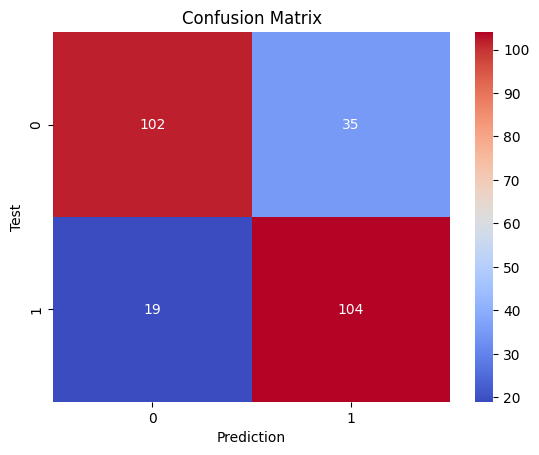

In [32]:
# Genereate a Confusion Matrrix.
conf_mat = confusion_matrix(y_test_balance, y_pred_lr)
heatmap = sns.heatmap(conf_mat, annot=True, fmt='g', cmap='coolwarm')
plt.xlabel('Prediction')
plt.ylabel('Test')
plt.title('Confusion Matrix')
plt.show(heatmap)

#### Interpretation:

The model recognised 102 instances where the given non-toxic text was actually non-toxic (0), however the model misclasifiied the given text as toxic (1) in 35 instances. The model recognised 104 instances where the given toxic text was actually toxic (1), however the model misclasifiied the given text as non-toxic (0) in 19 instances.

The accuracy value is calculated as follows (TP+TN)/(TP+TN+FP+FN) which gives a value of 0.7923, indicating that the ratio of correctly predicted instances to the total instances is high. The precision value is calculated as follows TP/(TP+FP) which gives a value of 0.7981, indicating that a high value of the predicted positive cases were actually positive. The recall value is calculated as follows TP/(TP+FN) which gives a value of 0.7923, indicating a high value where positive cases were correctly identified. The F1-score value is calculated as follows Formula: 2×(Precision×Recall)/(Precision+Recall) which gives a value of 0.7922.  

# Clustering

#### Term Frequency-Inverse Document Frequency (TF-IDF)
Evaluates how important a word is to a document relative to a collection of documents.

In [33]:
# create vectorizer 
vectorizer = TfidfVectorizer(stop_words='english') 

# Store the clean text
texts = comments['clean_text'].values

# vectorizer the text documents 
vectorized_documents = vectorizer.fit_transform(texts) 
vectorized_documents.shape

(5000, 16676)

####  Principal Component Analysis (PCA)
Dimensionality reduction technique

In [34]:
pca = PCA(n_components=2)

# Obtain components
principal_components = pca.fit_transform(vectorized_documents.toarray())
principal_components.shape

(5000, 2)

####  K-Means Clustering

In [1]:
# KMeans Clustering
num_clusters = 2
kmeans = KMeans(n_clusters=num_clusters, n_init=5, max_iter=500, random_state=42).fit(vectorized_documents) 

NameError: name 'KMeans' is not defined

####  Plotting 

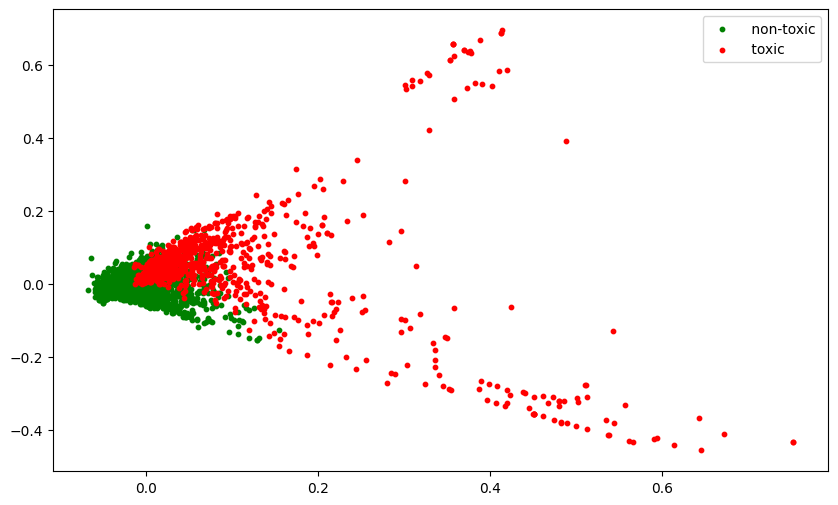

In [36]:
# Set the figure size
plt.figure(figsize=(10, 6))  # Adjust width and height as needed

# plot the results 
colors = ['green', 'red'] 
cluster = ['non-toxic', 'toxic']
for i in range(num_clusters): 
    plt.scatter(principal_components[kmeans.labels_ == i, 0], 
                principal_components[kmeans.labels_ == i, 1],  
                s=10, color=colors[i],  
                label=f' {cluster[i]}') 
# Add legend
plt.legend()
plt.show()

# Report
This analysis demonstrates the feasibility of classifying comments into toxic and non-toxic categories with good accuracy. Future work could involve refining the model with more advanced techniques (e.g., deep learning) and expanding the dataset to include more diverse examples. Limitations include potential biases in the dataset and the challenges of context understanding in comments